# 주요 패키지 설치 및 로드

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!pip install seirsplus

     |████████████████████████████████| 71kB 2.0MB/s 
  Created wheel for seirsplus: filename=seirsplus-1.0.9-cp36-none-any.whl size=64634 sha256=eef8a75a2276b9d7f7e25720ce658d092fd5e5547bebcf49afe2f797f2d4a4a2
  Stored in directory: /root/.cache/pip/wheels/f0/83/18/7b9b20364e2740f54c21cf5b3ebfde5a8a93071e098782c705
Successfully built seirsplus


In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial import distance

from seirsplus.models import *
from seirsplus.networks import *
from seirsplus.sim_loops import *
from seirsplus.utilities import *

In [ ]:
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/content/drive/My Drive/Data_Analysis_Competitions/Misc/Fonts/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
fm._rebuild()

The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 144487 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [ ]:
data_dir = '/content/drive/My Drive/Data_Analysis_Competitions/BigCon/외부데이터/서울시공공데이터/'

# 교통수단별 네트워크 생성 코드

## 지하철

In [ ]:
subway_full_nodes = [
    (x, y)
    for x in np.linspace(0, 3.12, 8)
    for y in np.linspace(0, 19.5, 46)
]

subway_full_edges = [
    (n1, n2)
    for n1 in subway_full_nodes
    for n2 in subway_full_nodes
    if (n1 != n2) and (distance.euclidean(n1, n2)) <= 2.0
]

subway_full_network = nx.Graph()
subway_full_network.add_nodes_from(subway_full_nodes)
subway_full_network.add_edges_from(subway_full_edges)

subway_seats_indexes = {
    0, 1, 2,
    8, 9, 10, 11, 12, 13, 14,
    19, 20, 21, 22, 23, 24, 25,
    31, 32, 33, 34, 35, 36, 37,
    43, 44, 45
}

subway_seat_nodes = set(
    (x, y)
    for i, x in enumerate(np.linspace(0, 3.12, 8))
    for j, y in enumerate(np.linspace(0, 19.5, 46))
    if i in {0, 7} and j in subway_seats_indexes
)


def subway_probs_with_seat_info(full_nodes, seat_nodes):
    num_seats = len(seat_nodes)
    num_aisles = len(full_nodes) - len(seat_nodes)
    num_total = len(full_nodes)
    
    seat_ratio = num_seats / num_total
    seat_prob = seat_ratio * 0.1 / num_seats # 의자가 빌 확률은 통로가 빌 확률보다 10배 낮음
    
    aisle_ratio = num_aisles / num_total
    aisle_prob = (aisle_ratio + seat_ratio * 0.9) / num_aisles
    
    probs = [
        seat_prob if node in seat_nodes else aisle_prob 
        for node in full_nodes
    ]
    
    return probs


def subway_network_generator(passenger_count):
    MAX_PASSENGER = 368
    
    if passenger_count < 1 or MAX_PASSENGER < passenger_count:
        print('too little or too many passengers: %d (1 ~ %d)' 
              % passenger_count, MAX_PASSENGER)        

    G = subway_full_network.copy()
        
    if passenger_count == MAX_PASSENGER:
        return G
    
    dropoff = MAX_PASSENGER - passenger_count
    sample = [subway_full_nodes[idx] 
              for idx in np.random.choice(MAX_PASSENGER, 
                                          dropoff, 
                                          replace=False, 
                                          p=subway_probs_with_seat_info(subway_full_nodes, subway_seat_nodes))]
    G.remove_nodes_from(sample)
    
    return G


def draw_subway_network(G):
    plt.subplots(figsize=(5, 20))
    nx.draw(G, {n1: n1 for n1 in subway_full_nodes})
    plt.show()
    
    
def hist_degree(G):
    plt.hist(dict(G.degree()).values())

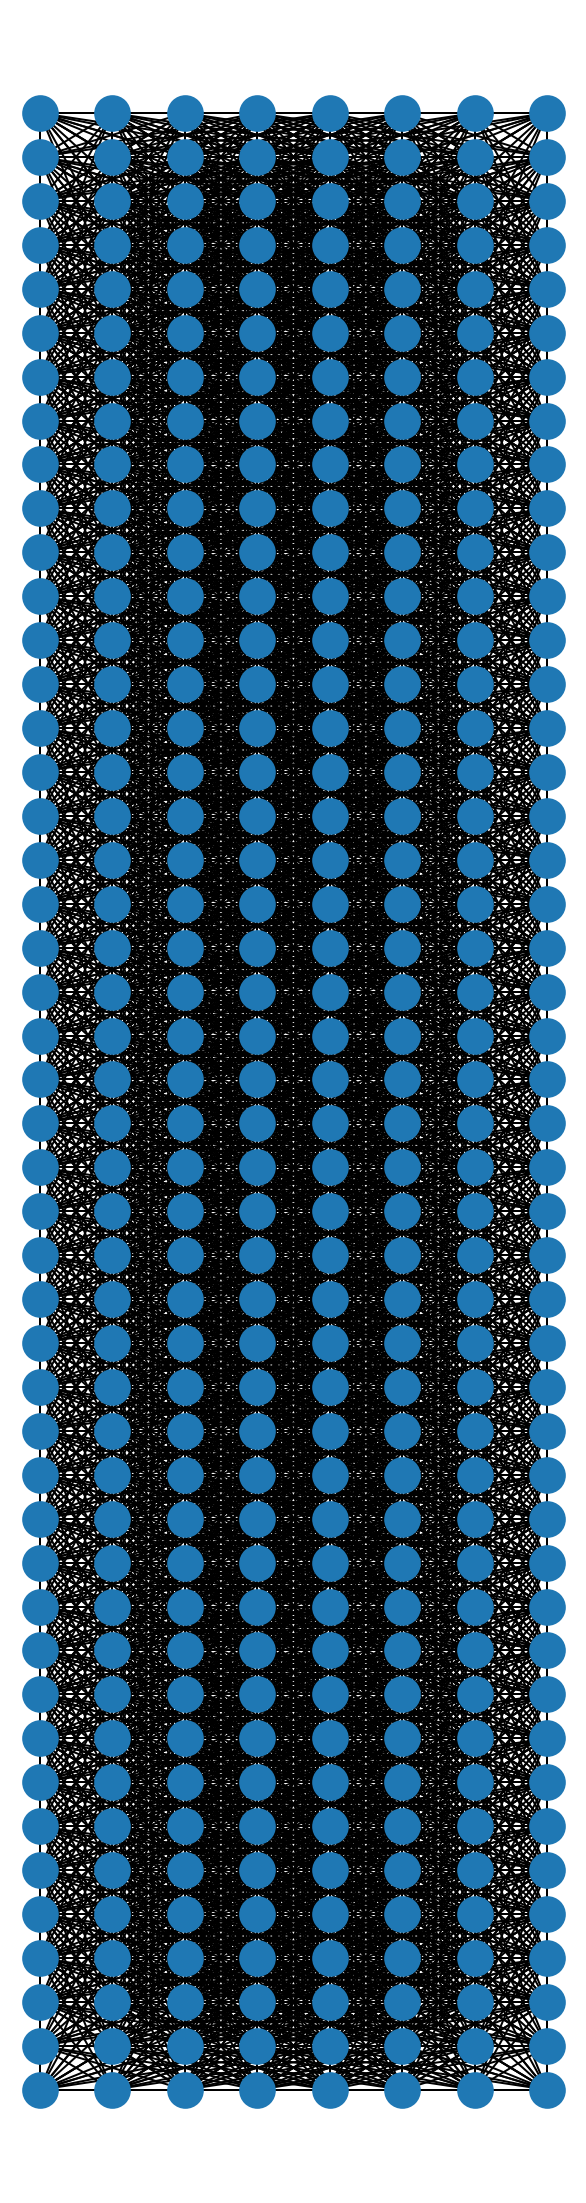

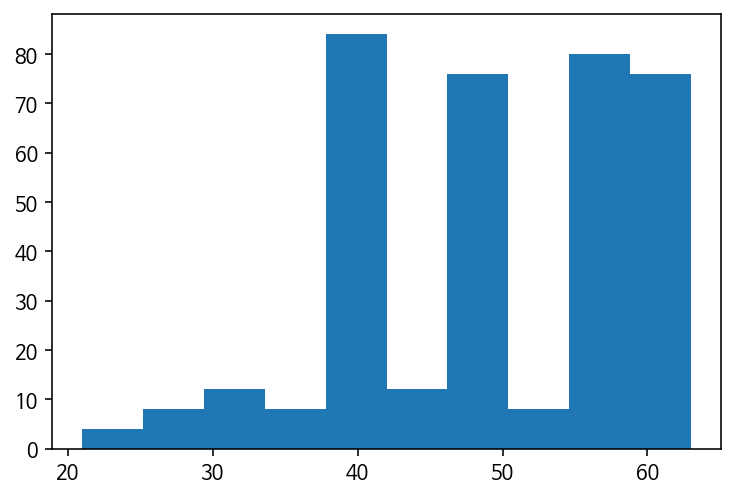

In [ ]:
G = subway_network_generator(368)
draw_subway_network(G)
hist_degree(G)

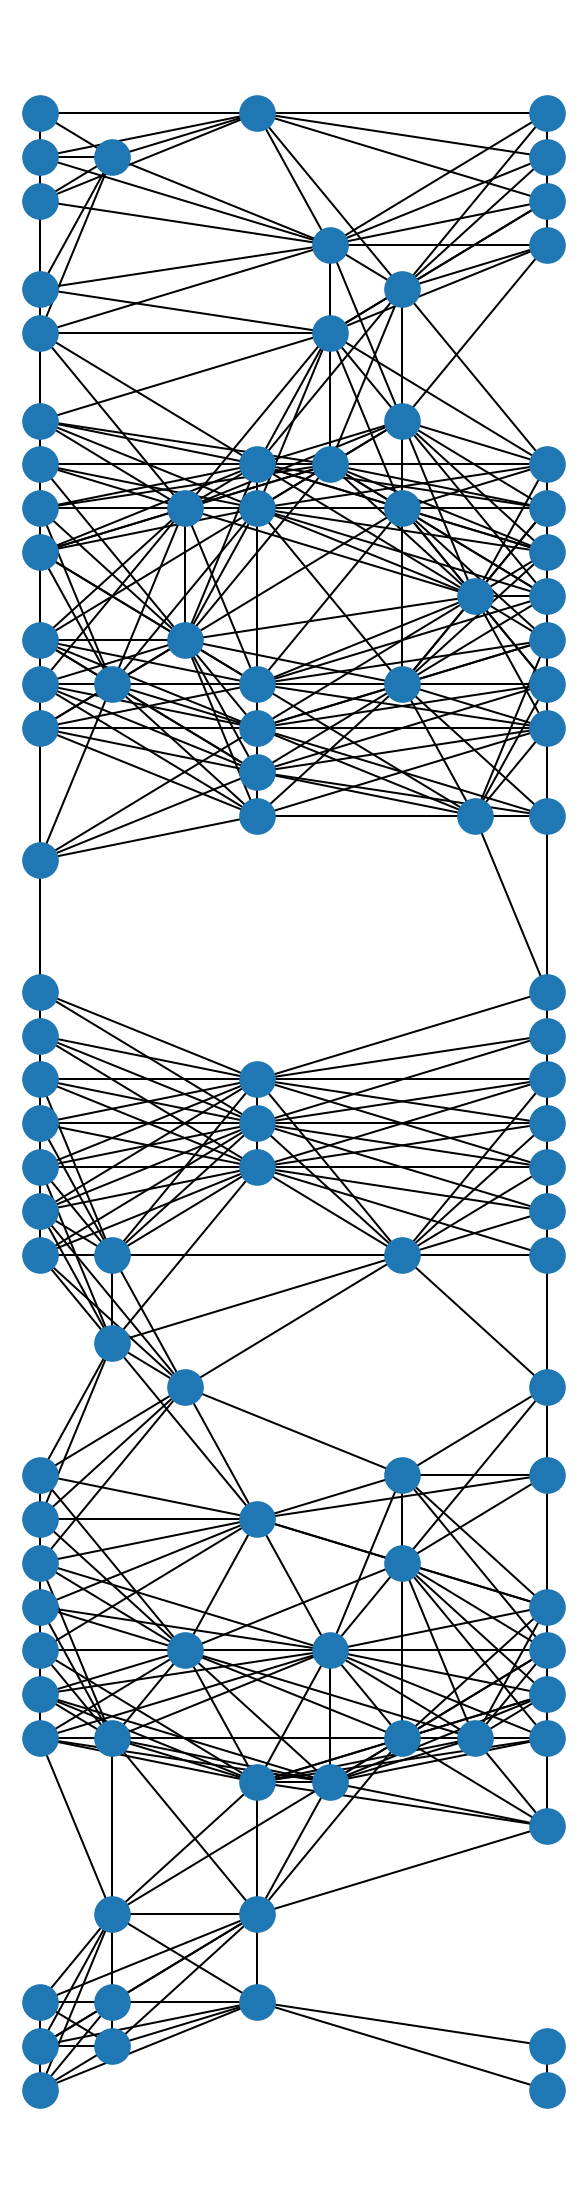

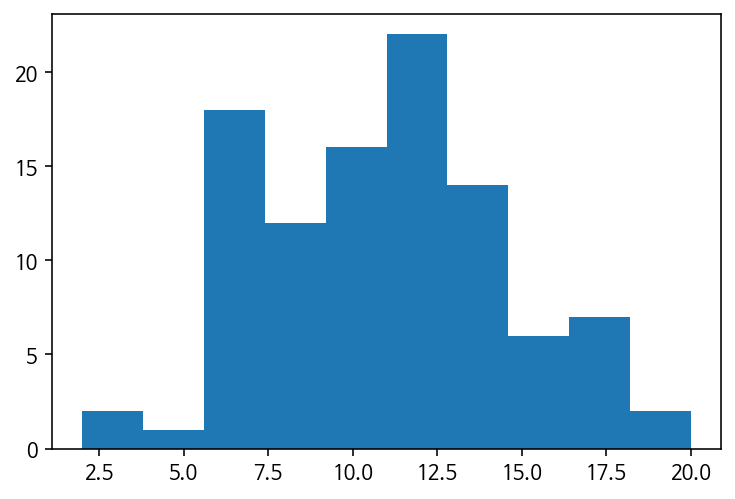

In [ ]:
G = subway_network_generator(100)
draw_subway_network(G)
hist_degree(G)

## 일반버스

In [ ]:
# https://korealand.tistory.com/6208
# https://m.blog.naver.com/chou06122/220791592555

bus_full_nodes = [
    (x, y)
    for y, num_line in zip(np.linspace(0, 10.95, 12), [5]*2 + [6]*10)
    for x in np.linspace(0, 2.29, num_line)
]

bus_full_edges = [
    (n1, n2)
    for n1 in bus_full_nodes
    for n2 in bus_full_nodes
    if (n1 != n2) and (distance.euclidean(n1, n2)) <= 2.0
]

bus_full_network = nx.Graph()
bus_full_network.add_nodes_from(bus_full_nodes)
bus_full_network.add_edges_from(bus_full_edges)

bus_seats_indexes = {
    (0, 0), (1, 0), (2, 0), (3, 0), (4, 0), # 뒷자리
    (0, 1), (1, 1),         (3, 1), (4, 1),
    (0, 2),                         (5, 2),
    (0, 3),                         (5, 3),
    (5, 7), (5, 8), (5, 9), # 앞쪽 오른편
    (0, 6), (0, 7), (0, 8), (0, 9) # 앞쪽 왼편
}

bus_seat_nodes = set(
    (x, y)
    for j, (y, num_line) in enumerate(zip(np.linspace(0, 10.95, 12), [5]*2 + [6]*10))
    for i, x in enumerate(np.linspace(0, 2.29, num_line))
    if (i, j) in bus_seats_indexes
)

bus_driver_seat_node = (0, 10.95)


def bus_probs_with_seat_info(full_nodes, seat_nodes):
    num_seats = len(seat_nodes)
    num_aisles = len(full_nodes) - len(seat_nodes) - 1
    num_total = len(full_nodes) - 1
    
    seat_ratio = num_seats / num_total
    seat_prob = seat_ratio * 0.1 / num_seats # 의자가 빌 확률은 통로가 빌 확률보다 10배 낮음
    
    aisle_ratio = num_aisles / num_total
    aisle_prob = (aisle_ratio + seat_ratio * 0.9) / num_aisles
    
    probs = [
        0 if node == bus_driver_seat_node else
        seat_prob if node in seat_nodes else 
        aisle_prob 
        for node in full_nodes
    ]
    
    return probs


def bus_network_generator(passenger_count):
    MAX_PASSENGER = 70
    
    if passenger_count < 1 or MAX_PASSENGER < passenger_count:
        print('too little or too many passengers: %d (1 ~ %d)' % passenger_count, MAX_PASSENGER)
        
    G = bus_full_network.copy()
        
    if passenger_count == MAX_PASSENGER:
        return G
    
    dropoff = MAX_PASSENGER - passenger_count
    sample = [bus_full_nodes[idx] 
              for idx in np.random.choice(MAX_PASSENGER, 
                                          dropoff, 
                                          replace=False,
                                          p=bus_probs_with_seat_info(bus_full_nodes, bus_seat_nodes))]
    G.remove_nodes_from(sample)
    
    return G


def draw_bus_network(G):
    plt.subplots(figsize=(5, 20))
    nx.draw(G, {n1: n1 for n1 in bus_full_nodes})
    plt.show()
    

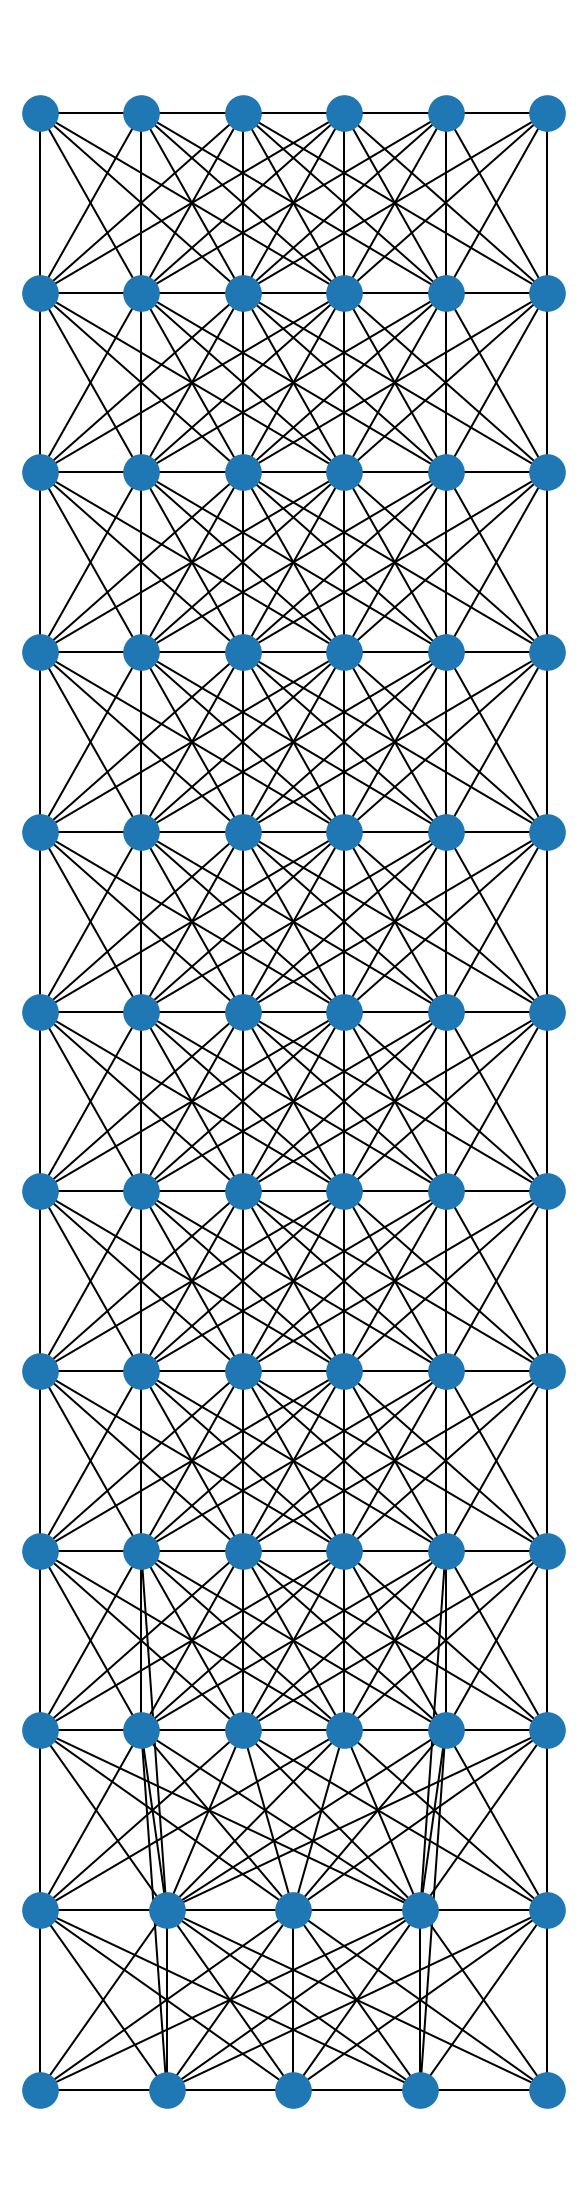

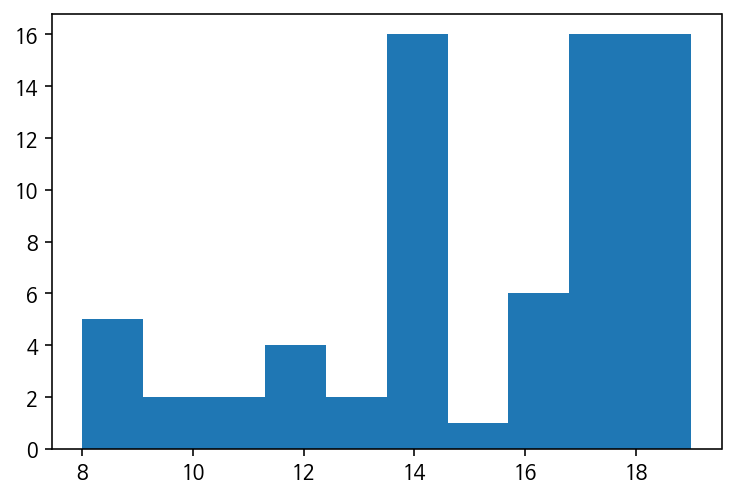

In [ ]:
G = bus_network_generator(70)
draw_bus_network(G)
hist_degree(G)

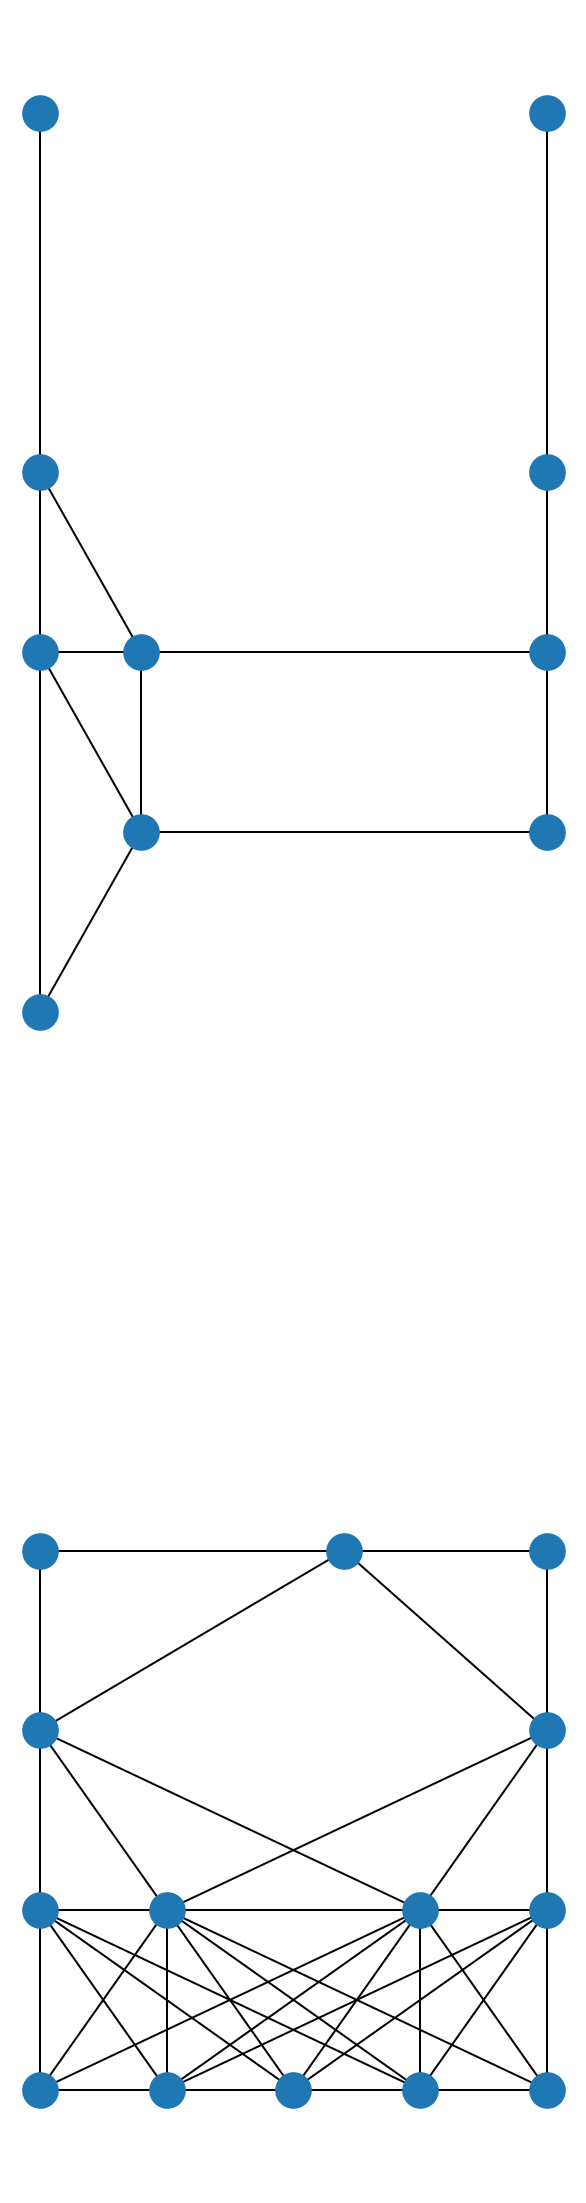

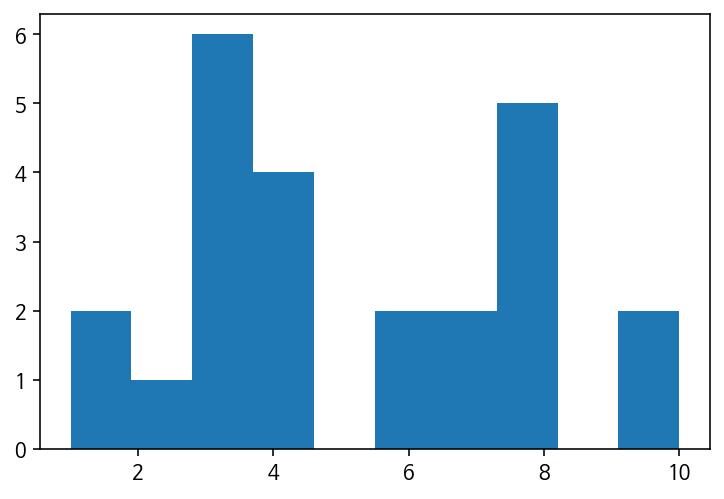

In [ ]:
G = bus_network_generator(24)
draw_bus_network(G)
hist_degree(G)

# seirsplus

## 네트워크 생성

In [ ]:
N = 10 # 총 탑승인원 수
INIT_EXPOSED = 1 # 최초 노출

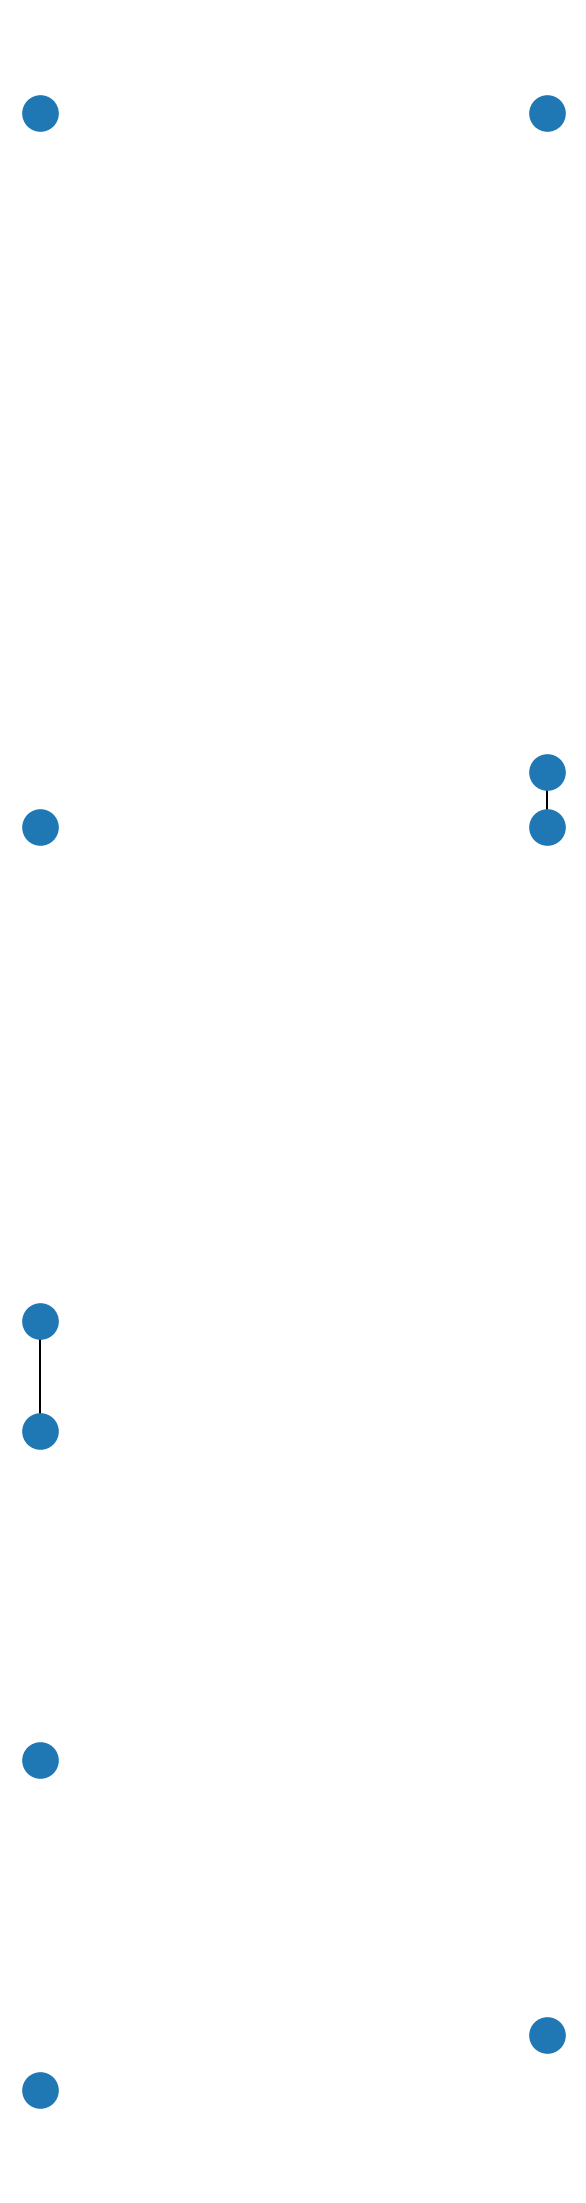

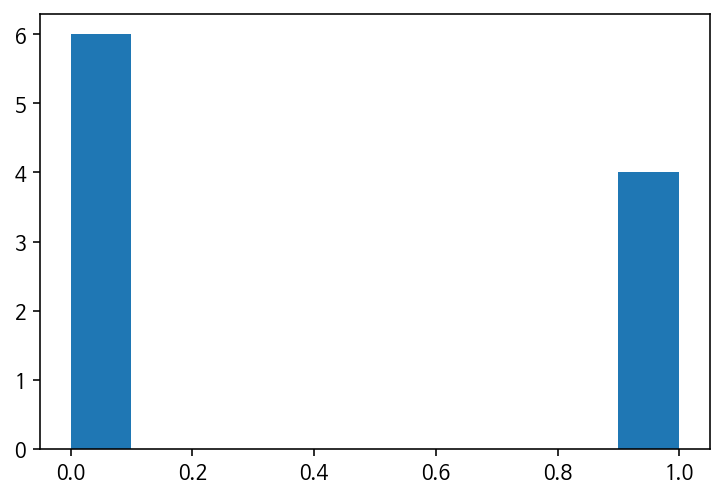

In [ ]:
G = subway_network_generator(N)
draw_subway_network(G)
hist_degree(G)

Baseline:
Degree: mean = 0.40, std = 0.49, 95% CI = (0.00, 1.00)
        coeff var = 1.22
Assortativity:    nan
Clustering coeff: 0.00



/usr/local/lib/python3.6/dist-packages/networkx/algorithms/assortativity/correlation.py:288: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / numpy.sqrt(vara * varb)


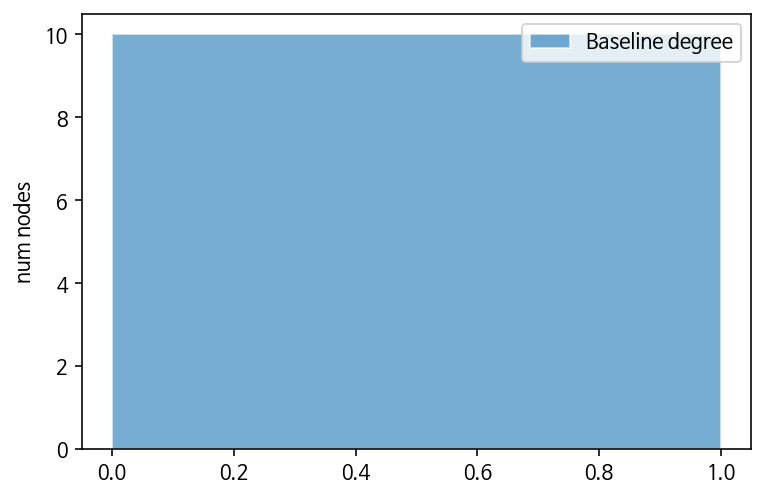

In [ ]:
network_info(G, "Baseline", plot=True)

### 네트워크 노드 이름을 (x, y) 좌표에서 인덱스 번호로 재레이블링
* 이렇게 해야 마지막 simulation에서 오류 안 남

In [ ]:
node_index_dict = {node: i for i, node in enumerate(G.nodes)}
G = nx.relabel_nodes(G, node_index_dict)

## 파라미터 설정

### 질병 진행 관련 파라미터 설정

latent period:  mean = 2.68, std = 1.65, 95% CI = (0.62, 6.12)

pre-symptomatic period:  mean = 3.80, std = 2.20, 95% CI = (0.98, 7.87)

total incubation period:  mean = 6.48, std = 2.13, 95% CI = (2.92, 9.67)



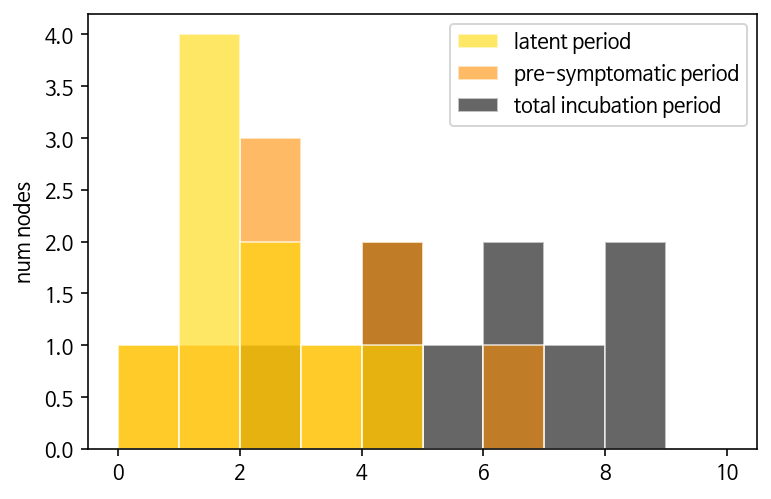

In [ ]:
latentPeriod_mean, latentPeriod_coeffvar = 3.0, 0.6
SIGMA   = 1 / gamma_dist(latentPeriod_mean, latentPeriod_coeffvar, N)

presymptomaticPeriod_mean, presymptomaticPeriod_coeffvar = 2.2, 0.5
LAMDA   = 1 / gamma_dist(presymptomaticPeriod_mean, presymptomaticPeriod_coeffvar, N)

dist_info([1/LAMDA, 1/SIGMA, 1/LAMDA+1/SIGMA], ["latent period", "pre-symptomatic period", "total incubation period"], plot=True, colors=['gold', 'darkorange', 'black'], reverse_plot=True)

pre-symptomatic period:  mean = 2.68, std = 1.65, 95% CI = (0.62, 6.12)

(a)symptomatic period:  mean = 3.79, std = 1.15, 95% CI = (2.28, 5.48)

total infectious period:  mean = 6.47, std = 1.56, 95% CI = (4.18, 9.32)



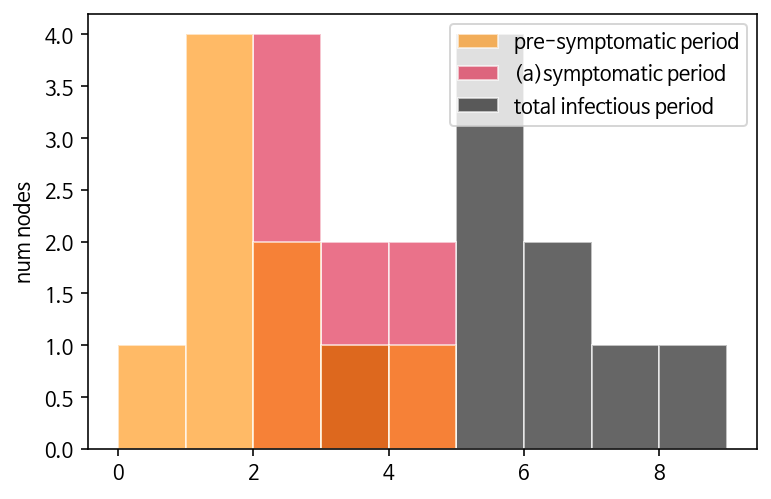

In [ ]:
symptomaticPeriod_mean, symptomaticPeriod_coeffvar = 4.0, 0.4
GAMMA   = 1 / gamma_dist(symptomaticPeriod_mean, symptomaticPeriod_coeffvar, N)

infectiousPeriod = 1/LAMDA + 1/GAMMA

dist_info([1/LAMDA, 1/GAMMA, 1/LAMDA+1/GAMMA], ["pre-symptomatic period", "(a)symptomatic period", "total infectious period"], plot=True, colors=['darkorange', 'crimson', 'black'], reverse_plot=True)

onset-to-hospitalization period:  mean = 13.72, std = 6.14, 95% CI = (8.11, 27.02)

hospitalization-to-discharge period:  mean = 11.50, std = 6.03, 95% CI = (7.30, 25.24)

onset-to-discharge period:  mean = 25.22, std = 8.55, 95% CI = (16.69, 41.04)



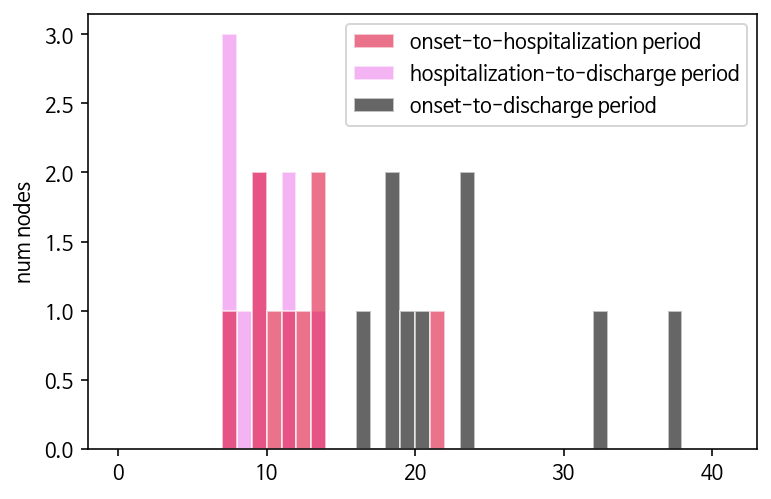

In [ ]:
onsetToHospitalizationPeriod_mean, onsetToHospitalizationPeriod_coeffvar = 11.0, 0.45
ETA     = 1 / gamma_dist(onsetToHospitalizationPeriod_mean, onsetToHospitalizationPeriod_coeffvar, N)

hospitalizationToDischargePeriod_mean, hospitalizationToDischargePeriod_coeffvar = 11.0, 0.45
GAMMA_H = 1 / gamma_dist(hospitalizationToDischargePeriod_mean, hospitalizationToDischargePeriod_coeffvar, N)

dist_info([1/ETA, 1/GAMMA_H, 1/ETA+1/GAMMA_H], ["onset-to-hospitalization period", "hospitalization-to-discharge period", "onset-to-discharge period"], plot=True, colors=['crimson', 'violet', 'black'], reverse_plot=True)

onset-to-hospitalization period:  mean = 13.72, std = 6.14, 95% CI = (8.11, 27.02)

hospitalization-to-death period:  mean = 6.40, std = 2.90, 95% CI = (2.40, 10.63)

onset-to-death period:  mean = 20.12, std = 7.74, 95% CI = (12.54, 35.34)



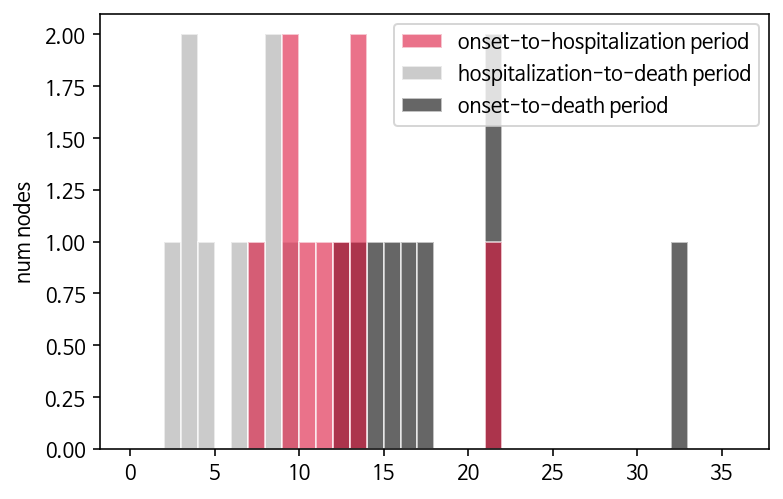

In [ ]:
hospitalizationToDeathPeriod_mean, hospitalizationToDeathPeriod_coeffvar = 7.0, 0.45
MU_H    = 1 / gamma_dist(hospitalizationToDeathPeriod_mean, hospitalizationToDeathPeriod_coeffvar, N)

dist_info([1/ETA, 1/MU_H, 1/ETA+1/MU_H], ["onset-to-hospitalization period", "hospitalization-to-death period", "onset-to-death period"], plot=True, colors=['crimson', 'darkgray', 'black'], reverse_plot=True)

#### 심각도 파라미터 설정

In [ ]:
PCT_ASYMPTOMATIC = 0.25
PCT_HOSPITALIZED = 0.035
PCT_FATALITY = 0.08

#### 전염 파라미터 설정

Individual R0:  mean = 0.46, std = 0.07, 95% CI = (0.37, 0.61)



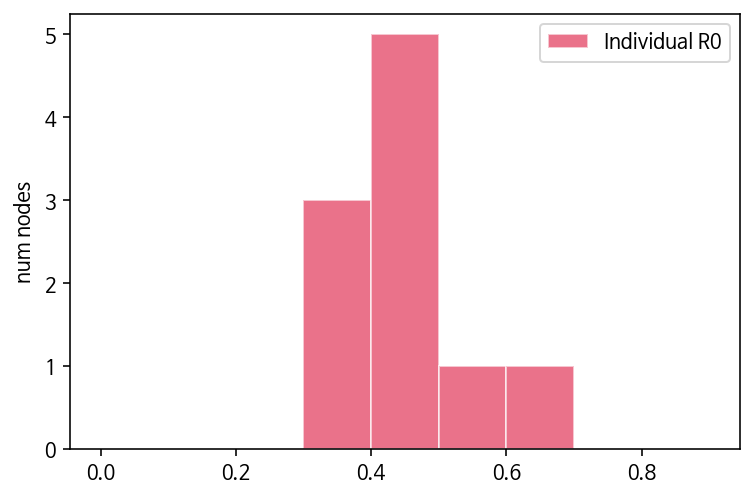

In [ ]:
R0_mean     = 0.5 # 2.0
R0_coeffvar = 0.2

R0 = gamma_dist(R0_mean, R0_coeffvar, N)

dist_info(R0, "Individual R0", bin_size=0.1, plot=True, colors='crimson')

In [ ]:
BETA = 1/infectiousPeriod * R0

In [ ]:
P_GLOBALINTXN = 0.4

### 검사/추적/격리(TTI) 개입 프로토콜 파라미터 설정

In [ ]:
INTERVENTION_START_PCT_INFECTED = 0/100
AVERAGE_INTRODUCTIONS_PER_DAY   = 1/14          # expected number of new exogenous exposures per day

TESTING_CADENCE                 = 'weekly'      # how often to do testing (other than self-reporting symptomatics who can get tested any day)
PCT_TESTED_PER_DAY              = 0.0           # max daily test allotment defined as a percent of population size
TEST_FALSENEG_RATE              = 'temporal'    # test false negative rate, will use FN rate that varies with disease time
MAX_PCT_TESTS_FOR_SYMPTOMATICS  = 0.0           # max percent of daily test allotment to use on self-reporting symptomatics
MAX_PCT_TESTS_FOR_TRACES        = 0.0           # max percent of daily test allotment to use on contact traces
RANDOM_TESTING_DEGREE_BIAS      = 0             # magnitude of degree bias in random selections for testing, none here

PCT_CONTACTS_TO_TRACE           = 0.0           # percentage of primary cases' contacts that are traced
TRACING_LAG                     = 2             # number of cadence testing days between primary tests and tracing tests

ISOLATION_LAG_SYMPTOMATIC       = 1             # number of days between onset of symptoms and self-isolation of symptomatics
ISOLATION_LAG_POSITIVE          = 2             # test turn-around time (TAT): number of days between administration of test and isolation of positive cases
ISOLATION_LAG_CONTACT           = 0             # number of days between a contact being traced and that contact self-isolating

#### 개입 순응도 파라미터 설정

In [ ]:
TESTING_COMPLIANCE_RATE_SYMPTOMATIC                  = 0.0    
TESTING_COMPLIANCE_RATE_TRACED                       = 0.0
TESTING_COMPLIANCE_RATE_RANDOM                       = 0.0  # Assume employee testing is mandatory, so 100% compliance

TRACING_COMPLIANCE_RATE                              = 0.0

ISOLATION_COMPLIANCE_RATE_SYMPTOMATIC_INDIVIDUAL     = 0.0
ISOLATION_COMPLIANCE_RATE_SYMPTOMATIC_GROUPMATE      = 0.0
ISOLATION_COMPLIANCE_RATE_POSITIVE_INDIVIDUAL        = 0.0
ISOLATION_COMPLIANCE_RATE_POSITIVE_GROUPMATE         = 0.0  # Isolate teams with a positive member, but suppose 20% of employees are essential workforce
ISOLATION_COMPLIANCE_RATE_POSITIVE_CONTACT           = 0.0
ISOLATION_COMPLIANCE_RATE_POSITIVE_CONTACTGROUPMATE  = 0.0

In [ ]:
TESTING_COMPLIANCE_RANDOM                        = (numpy.random.rand(N) < TESTING_COMPLIANCE_RATE_RANDOM)
TESTING_COMPLIANCE_TRACED                        = (numpy.random.rand(N) < TESTING_COMPLIANCE_RATE_TRACED)
TESTING_COMPLIANCE_SYMPTOMATIC                   = (numpy.random.rand(N) < TESTING_COMPLIANCE_RATE_SYMPTOMATIC)

TRACING_COMPLIANCE                               = (numpy.random.rand(N) < TRACING_COMPLIANCE_RATE)

ISOLATION_COMPLIANCE_SYMPTOMATIC_INDIVIDUAL      = (numpy.random.rand(N) < ISOLATION_COMPLIANCE_RATE_SYMPTOMATIC_INDIVIDUAL)
ISOLATION_COMPLIANCE_SYMPTOMATIC_GROUPMATE       = (numpy.random.rand(N) < ISOLATION_COMPLIANCE_RATE_SYMPTOMATIC_GROUPMATE)
ISOLATION_COMPLIANCE_POSITIVE_INDIVIDUAL         = (numpy.random.rand(N) < ISOLATION_COMPLIANCE_RATE_POSITIVE_INDIVIDUAL)
ISOLATION_COMPLIANCE_POSITIVE_GROUPMATE          = (numpy.random.rand(N) < ISOLATION_COMPLIANCE_RATE_POSITIVE_GROUPMATE)
ISOLATION_COMPLIANCE_POSITIVE_CONTACT            = (numpy.random.rand(N) < ISOLATION_COMPLIANCE_RATE_POSITIVE_CONTACT)
ISOLATION_COMPLIANCE_POSITIVE_CONTACTGROUPMATE   = (numpy.random.rand(N) < ISOLATION_COMPLIANCE_RATE_POSITIVE_CONTACTGROUPMATE)

## 모델 initialization 및 시뮬레이션

In [ ]:
model = ExtSEIRSNetworkModel(G=G, 
                             p=P_GLOBALINTXN,
                             beta=BETA, sigma=SIGMA, lamda=LAMDA, gamma=GAMMA, 
                             gamma_asym=GAMMA, eta=ETA, gamma_H=GAMMA_H, mu_H=MU_H, 
                             a=PCT_ASYMPTOMATIC, h=PCT_HOSPITALIZED, f=PCT_FATALITY,
                             # G_Q=G_quarantine, 
                             isolation_time=14,
                             initE=INIT_EXPOSED)

T = 30 # 최대 시뮬레이션 기간(일)

run_tti_sim(model, T, 
            intervention_start_pct_infected=INTERVENTION_START_PCT_INFECTED, average_introductions_per_day=AVERAGE_INTRODUCTIONS_PER_DAY,
            testing_cadence=TESTING_CADENCE, pct_tested_per_day=PCT_TESTED_PER_DAY, test_falseneg_rate=TEST_FALSENEG_RATE, 
            testing_compliance_symptomatic=TESTING_COMPLIANCE_SYMPTOMATIC, max_pct_tests_for_symptomatics=MAX_PCT_TESTS_FOR_SYMPTOMATICS,
            testing_compliance_traced=TESTING_COMPLIANCE_TRACED, max_pct_tests_for_traces=MAX_PCT_TESTS_FOR_TRACES,
            testing_compliance_random=TESTING_COMPLIANCE_RANDOM, random_testing_degree_bias=RANDOM_TESTING_DEGREE_BIAS,
            tracing_compliance=TRACING_COMPLIANCE, pct_contacts_to_trace=PCT_CONTACTS_TO_TRACE, tracing_lag=TRACING_LAG,
            isolation_compliance_symptomatic_individual=ISOLATION_COMPLIANCE_SYMPTOMATIC_INDIVIDUAL, isolation_compliance_symptomatic_groupmate=ISOLATION_COMPLIANCE_SYMPTOMATIC_GROUPMATE, 
            isolation_compliance_positive_individual=ISOLATION_COMPLIANCE_POSITIVE_INDIVIDUAL, isolation_compliance_positive_groupmate=ISOLATION_COMPLIANCE_POSITIVE_GROUPMATE,
            isolation_compliance_positive_contact=ISOLATION_COMPLIANCE_POSITIVE_CONTACT, isolation_compliance_positive_contactgroupmate=ISOLATION_COMPLIANCE_POSITIVE_CONTACTGROUPMATE,
            isolation_lag_symptomatic=ISOLATION_LAG_SYMPTOMATIC, isolation_lag_positive=ISOLATION_LAG_POSITIVE, 
            isolation_groups=[[]])

[INTERVENTIONS @ t = 1.29 (1 (10.00%) infected)]
	0	tested due to symptoms  [+ 0 positive (0.00 %) +]
	0	tested as traces        [+ 0 positive (0.00 %) +]
	0	tested randomly         [+ 0 positive (0.00 %) +]
	0	tested TOTAL            [+ 0 positive (0.00 %) +]
	0 will isolate due to symptoms         (0 as groupmates of symptomatic)
	0 will isolate due to positive test    (0 as groupmates of positive)
	0 will isolate due to positive contact (0 as groupmates of contact)
	0 entered isolation
[INTERVENTIONS @ t = 2.61 (2 (20.00%) infected)]
	0	tested due to symptoms  [+ 0 positive (0.00 %) +]
	0	tested as traces        [+ 0 positive (0.00 %) +]
	0	tested randomly         [+ 0 positive (0.00 %) +]
	0	tested TOTAL            [+ 0 positive (0.00 %) +]
	0 will isolate due to symptoms         (0 as groupmates of symptomatic)
	0 will isolate due to positive test    (0 as groupmates of positive)
	0 will isolate due to positive contact (0 as groupmates of contact)
	0 entered isolation
[INTERVENTIO

(1.2901517120268053, 12.99802666296177)

```
def results_summary(model):
    print("total percent infected: %0.2f%%" % ((model.total_num_infected()[-1]+model.total_num_recovered()[-1])/model.numNodes * 100) )
    print("total percent fatality: %0.2f%%" % (model.numF[-1]/model.numNodes * 100) )
    print("peak  pct hospitalized: %0.2f%%" % (numpy.max(model.numH)/model.numNodes * 100) )
```

In [ ]:
results_summary(model)

total percent infected: 20.00%
total percent fatality: 0.00%
peak  pct hospitalized: 0.00%


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


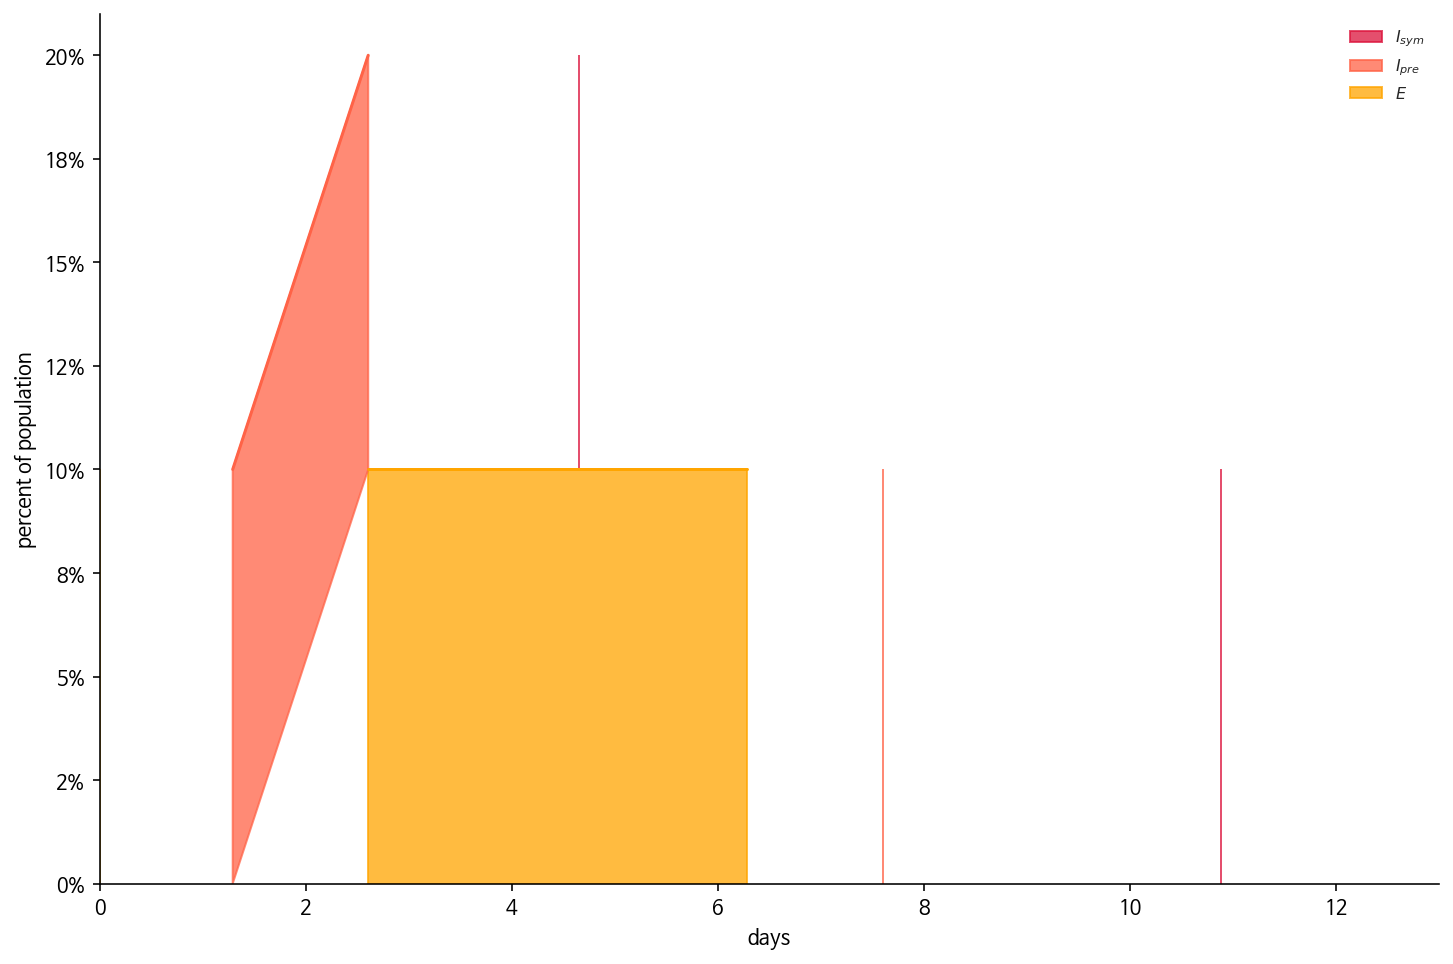

In [ ]:
fig, ax = model.figure_infections(combine_Q_infected=False, 
                                  plot_Q_R='stacked', 
                                  plot_Q_S='stacked')

In [ ]:
total_percent_infected = (model.total_num_infected()[-1]+model.total_num_recovered()[-1])/model.numNodes * 100
total_percent_infected

0.8152173913043478

## 함수화

### sim_loops.py의 run_tts_sim print 주석처리

In [ ]:
from __future__ import division
import pickle
import numpy

import time



def run_tti_sim(model, T, 
                intervention_start_pct_infected=0, average_introductions_per_day=0,
                testing_cadence='everyday', pct_tested_per_day=1.0, test_falseneg_rate='temporal', 
                testing_compliance_symptomatic=[None], max_pct_tests_for_symptomatics=1.0,
                testing_compliance_traced=[None], max_pct_tests_for_traces=1.0,
                testing_compliance_random=[None], random_testing_degree_bias=0,
                tracing_compliance=[None], num_contacts_to_trace=None, pct_contacts_to_trace=1.0, tracing_lag=1,
                isolation_compliance_symptomatic_individual=[None], isolation_compliance_symptomatic_groupmate=[None], 
                isolation_compliance_positive_individual=[None], isolation_compliance_positive_groupmate=[None],
                isolation_compliance_positive_contact=[None], isolation_compliance_positive_contactgroupmate=[None],
                isolation_lag_symptomatic=1, isolation_lag_positive=1, isolation_lag_contact=0, isolation_groups=None,
                cadence_testing_days=None, cadence_cycle_length=28, temporal_falseneg_rates=None
                ):

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    # Testing cadences involve a repeating 28 day cycle starting on a Monday
    # (0:Mon, 1:Tue, 2:Wed, 3:Thu, 4:Fri, 5:Sat, 6:Sun, 7:Mon, 8:Tues, ...)
    # For each cadence, testing is done on the day numbers included in the associated list.

    if(cadence_testing_days is None):
        cadence_testing_days    = {
                                    'everyday':     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
                                    'workday':      [0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 14, 15, 16, 17, 18, 21, 22, 23, 24, 25],
                                    'semiweekly':   [0, 3, 7, 10, 14, 17, 21, 24],
                                    'weekly':       [0, 7, 14, 21],
                                    'biweekly':     [0, 14],
                                    'monthly':      [0],
                                    'cycle_start':  [0]
                                }

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    if(temporal_falseneg_rates is None):
        temporal_falseneg_rates = { 
                                    model.E:        {0: 1.00, 1: 1.00, 2: 1.00, 3: 1.00},
                                    model.I_pre:    {0: 0.25, 1: 0.25, 2: 0.22},
                                    model.I_sym:    {0: 0.19, 1: 0.16, 2: 0.16, 3: 0.17, 4: 0.19, 5: 0.22, 6: 0.26, 7: 0.29, 8: 0.34, 9: 0.38, 10: 0.43, 11: 0.48, 12: 0.52, 13: 0.57, 14: 0.62, 15: 0.66, 16: 0.70, 17: 0.76, 18: 0.79, 19: 0.82, 20: 0.85, 21: 0.88, 22: 0.90, 23: 0.92, 24: 0.93, 25: 0.95, 26: 0.96, 27: 0.97, 28: 0.97, 29: 0.98, 30: 0.98, 31: 0.99},
                                    model.I_asym:   {0: 0.19, 1: 0.16, 2: 0.16, 3: 0.17, 4: 0.19, 5: 0.22, 6: 0.26, 7: 0.29, 8: 0.34, 9: 0.38, 10: 0.43, 11: 0.48, 12: 0.52, 13: 0.57, 14: 0.62, 15: 0.66, 16: 0.70, 17: 0.76, 18: 0.79, 19: 0.82, 20: 0.85, 21: 0.88, 22: 0.90, 23: 0.92, 24: 0.93, 25: 0.95, 26: 0.96, 27: 0.97, 28: 0.97, 29: 0.98, 30: 0.98, 31: 0.99},
                                    model.Q_E:      {0: 1.00, 1: 1.00, 2: 1.00, 3: 1.00},
                                    model.Q_pre:    {0: 0.25, 1: 0.25, 2: 0.22},
                                    model.Q_sym:    {0: 0.19, 1: 0.16, 2: 0.16, 3: 0.17, 4: 0.19, 5: 0.22, 6: 0.26, 7: 0.29, 8: 0.34, 9: 0.38, 10: 0.43, 11: 0.48, 12: 0.52, 13: 0.57, 14: 0.62, 15: 0.66, 16: 0.70, 17: 0.76, 18: 0.79, 19: 0.82, 20: 0.85, 21: 0.88, 22: 0.90, 23: 0.92, 24: 0.93, 25: 0.95, 26: 0.96, 27: 0.97, 28: 0.97, 29: 0.98, 30: 0.98, 31: 0.99},
                                    model.Q_asym:   {0: 0.19, 1: 0.16, 2: 0.16, 3: 0.17, 4: 0.19, 5: 0.22, 6: 0.26, 7: 0.29, 8: 0.34, 9: 0.38, 10: 0.43, 11: 0.48, 12: 0.52, 13: 0.57, 14: 0.62, 15: 0.66, 16: 0.70, 17: 0.76, 18: 0.79, 19: 0.82, 20: 0.85, 21: 0.88, 22: 0.90, 23: 0.92, 24: 0.93, 25: 0.95, 26: 0.96, 27: 0.97, 28: 0.97, 29: 0.98, 30: 0.98, 31: 0.99},
                                  }

    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # Custom simulation loop:
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

    interventionOn         = False
    interventionStartTime  = None

    timeOfLastIntervention = -1
    timeOfLastIntroduction = -1

    testingDays            = cadence_testing_days[testing_cadence]
    cadenceDayNumber       = 0

    tests_per_day                 = int(model.numNodes * pct_tested_per_day)
    max_tracing_tests_per_day     = int(tests_per_day * max_pct_tests_for_traces)
    max_symptomatic_tests_per_day = int(tests_per_day * max_pct_tests_for_symptomatics)

    tracingPoolQueue              = [[] for i in range(tracing_lag)]
    isolationQueue_symptomatic    = [[] for i in range(isolation_lag_symptomatic)]
    isolationQueue_positive       = [[] for i in range(isolation_lag_positive)]
    isolationQueue_contact        = [[] for i in range(isolation_lag_contact)]

    model.tmax  = T
    running     = True
    while running:

        running = model.run_iteration()

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # Introduce exogenous exposures randomly:
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        if(int(model.t)!=int(timeOfLastIntroduction)):

            timeOfLastIntroduction = model.t

            numNewExposures = numpy.random.poisson(lam=average_introductions_per_day)
            
            model.introduce_exposures(num_new_exposures=numNewExposures)

            # if(numNewExposures > 0):
            #     print("[NEW EXPOSURE @ t = %.2f (%d exposed)]" % (model.t, numNewExposures))

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # Execute testing policy at designated intervals:
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

        if(int(model.t)!=int(timeOfLastIntervention)):
        
            cadenceDayNumber = int(model.t % cadence_cycle_length)

            timeOfLastIntervention = model.t

            currentNumInfected = model.total_num_infected()[model.tidx]
            currentPctInfected = model.total_num_infected()[model.tidx]/model.numNodes

            if(currentPctInfected >= intervention_start_pct_infected and not interventionOn):
                interventionOn        = True
                interventionStartTime = model.t
            
            if(interventionOn):

                # print("[INTERVENTIONS @ t = %.2f (%d (%.2f%%) infected)]" % (model.t, currentNumInfected, currentPctInfected*100))
                
                nodeStates                       = model.X.flatten()
                nodeTestedStatuses               = model.tested.flatten()
                nodeTestedInCurrentStateStatuses = model.testedInCurrentState.flatten()
                nodePositiveStatuses             = model.positive.flatten()

                #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

                # tracingPoolQueue[0] = tracingPoolQueue[0]Queue.pop(0)

                #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                
                newIsolationGroup_symptomatic = []
                newIsolationGroup_contact     = []

                #----------------------------------------
                # Isolate SYMPTOMATIC cases without a test:
                #----------------------------------------
                numSelfIsolated_symptoms = 0
                numSelfIsolated_symptomaticGroupmate = 0

                if(any(isolation_compliance_symptomatic_individual)):
                    symptomaticNodes = numpy.argwhere((nodeStates==model.I_sym)).flatten()
                    for symptomaticNode in symptomaticNodes:
                        if(isolation_compliance_symptomatic_individual[symptomaticNode]):
                            if(model.X[symptomaticNode] == model.I_sym):
                                numSelfIsolated_symptoms += 1   
                                newIsolationGroup_symptomatic.append(symptomaticNode)

                            #----------------------------------------
                            # Isolate the GROUPMATES of this SYMPTOMATIC node without a test:
                            #----------------------------------------
                            if(isolation_groups is not None and any(isolation_compliance_symptomatic_groupmate)):
                                isolationGroupmates = next((group for group in isolation_groups if symptomaticNode in group), None)
                                for isolationGroupmate in isolationGroupmates:
                                    if(isolationGroupmate != symptomaticNode):
                                        if(isolation_compliance_symptomatic_groupmate[isolationGroupmate]):
                                            numSelfIsolated_symptomaticGroupmate += 1
                                            newIsolationGroup_symptomatic.append(isolationGroupmate)


                #----------------------------------------
                # Isolate the CONTACTS of detected POSITIVE cases without a test:
                #----------------------------------------
                numSelfIsolated_positiveContact = 0
                numSelfIsolated_positiveContactGroupmate = 0

                if(any(isolation_compliance_positive_contact) or any(isolation_compliance_positive_contactgroupmate)):
                    for contactNode in tracingPoolQueue[0]:
                        if(isolation_compliance_positive_contact[contactNode]):
                            newIsolationGroup_contact.append(contactNode)
                            numSelfIsolated_positiveContact += 1 

                        #----------------------------------------
                        # Isolate the GROUPMATES of this self-isolating CONTACT without a test:
                        #----------------------------------------
                        if(isolation_groups is not None and any(isolation_compliance_positive_contactgroupmate)):
                            isolationGroupmates = next((group for group in isolation_groups if contactNode in group), None)
                            for isolationGroupmate in isolationGroupmates:
                                # if(isolationGroupmate != contactNode):
                                if(isolation_compliance_positive_contactgroupmate[isolationGroupmate]):
                                    newIsolationGroup_contact.append(isolationGroupmate)
                                    numSelfIsolated_positiveContactGroupmate += 1
                                    

                #----------------------------------------
                # Update the nodeStates list after self-isolation updates to model.X:
                #----------------------------------------
                nodeStates = model.X.flatten()


                #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


                #----------------------------------------
                # Allow SYMPTOMATIC individuals to self-seek tests
                # regardless of cadence testing days
                #----------------------------------------
                symptomaticSelection = []

                if(any(testing_compliance_symptomatic)):
                    
                    symptomaticPool = numpy.argwhere((testing_compliance_symptomatic==True)
                                                     & (nodeTestedInCurrentStateStatuses==False)
                                                     & (nodePositiveStatuses==False)
                                                     & ((nodeStates==model.I_sym)|(nodeStates==model.Q_sym))
                                                    ).flatten()

                    numSymptomaticTests  = min(len(symptomaticPool), max_symptomatic_tests_per_day)
                    
                    if(len(symptomaticPool) > 0):
                        symptomaticSelection = symptomaticPool[numpy.random.choice(len(symptomaticPool), min(numSymptomaticTests, len(symptomaticPool)), replace=False)]


                #----------------------------------------
                # Test individuals randomly and via contact tracing
                # on cadence testing days:
                #----------------------------------------

                tracingSelection = []
                randomSelection = []

                if(cadenceDayNumber in testingDays):

                    #----------------------------------------
                    # Apply a designated portion of this day's tests 
                    # to individuals identified by CONTACT TRACING:
                    #----------------------------------------

                    tracingPool = tracingPoolQueue.pop(0)

                    if(any(testing_compliance_traced)):

                        numTracingTests = min(len(tracingPool), min(tests_per_day-len(symptomaticSelection), max_tracing_tests_per_day))

                        for trace in range(numTracingTests):
                            traceNode = tracingPool.pop()
                            if((nodePositiveStatuses[traceNode]==False)
                                and (testing_compliance_traced[traceNode]==True)
                                and (model.X[traceNode] != model.R)
                                and (model.X[traceNode] != model.Q_R) 
                                and (model.X[traceNode] != model.H)
                                and (model.X[traceNode] != model.F)):
                                tracingSelection.append(traceNode)

                    #----------------------------------------
                    # Apply the remainder of this day's tests to random testing:
                    #----------------------------------------

                    if(any(testing_compliance_random)):
                        
                        testingPool = numpy.argwhere((testing_compliance_random==True)
                                                     & (nodePositiveStatuses==False)
                                                     & (nodeStates != model.R)
                                                     & (nodeStates != model.Q_R) 
                                                     & (nodeStates != model.H)
                                                     & (nodeStates != model.F)
                                                    ).flatten()

                        numRandomTests = max(min(tests_per_day-len(tracingSelection)-len(symptomaticSelection), len(testingPool)), 0)
                        
                        testingPool_degrees       = model.degree.flatten()[testingPool]
                        testingPool_degreeWeights = numpy.power(testingPool_degrees,random_testing_degree_bias)/numpy.sum(numpy.power(testingPool_degrees,random_testing_degree_bias))

                        if(len(testingPool) > 0):
                            randomSelection = testingPool[numpy.random.choice(len(testingPool), numRandomTests, p=testingPool_degreeWeights, replace=False)]

                
                #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


                #----------------------------------------
                # Perform the tests on the selected individuals:
                #----------------------------------------

                selectedToTest = numpy.concatenate((symptomaticSelection, tracingSelection, randomSelection)).astype(int)

                numTested                     = 0
                numTested_random              = 0
                numTested_tracing             = 0
                numTested_symptomatic         = 0
                numPositive                   = 0
                numPositive_random            = 0
                numPositive_tracing           = 0
                numPositive_symptomatic       = 0 
                numIsolated_positiveGroupmate = 0
                
                newTracingPool = []

                newIsolationGroup_positive = []

                for i, testNode in enumerate(selectedToTest):

                    model.set_tested(testNode, True)

                    numTested += 1
                    if(i < len(symptomaticSelection)):
                        numTested_symptomatic  += 1
                    elif(i < len(symptomaticSelection)+len(tracingSelection)):
                        numTested_tracing += 1
                    else:
                        numTested_random += 1                  

                    # If the node to be tested is not infected, then the test is guaranteed negative, 
                    # so don't bother going through with doing the test:
                    if(model.X[testNode] == model.S or model.X[testNode] == model.Q_S):
                        pass
                    # Also assume that latent infections are not picked up by tests:
                    elif(model.X[testNode] == model.E or model.X[testNode] == model.Q_E):
                        pass
                    elif(model.X[testNode] == model.I_pre or model.X[testNode] == model.Q_pre 
                         or model.X[testNode] == model.I_sym or model.X[testNode] == model.Q_sym 
                         or model.X[testNode] == model.I_asym or model.X[testNode] == model.Q_asym):
                        
                        if(test_falseneg_rate == 'temporal'):
                            testNodeState       = model.X[testNode][0]
                            testNodeTimeInState = model.timer_state[testNode][0]
                            if(testNodeState in list(temporal_falseneg_rates.keys())):
                                falseneg_prob = temporal_falseneg_rates[testNodeState][ int(min(testNodeTimeInState, max(list(temporal_falseneg_rates[testNodeState].keys())))) ]
                            else:
                                falseneg_prob = 1.00
                        else:
                            falseneg_prob = test_falseneg_rate

                        if(numpy.random.rand() < (1-falseneg_prob)):
                            # +++++++++++++++++++++++++++++++++++++++++++++
                            # The tested node has returned a positive test
                            # +++++++++++++++++++++++++++++++++++++++++++++
                            numPositive += 1
                            if(i < len(symptomaticSelection)):
                                numPositive_symptomatic  += 1
                            elif(i < len(symptomaticSelection)+len(tracingSelection)):
                                numPositive_tracing += 1
                            else:
                                numPositive_random += 1 
                            
                            # Update the node's state to the appropriate detected case state:
                            model.set_positive(testNode, True)

                            #----------------------------------------
                            # Add this positive node to the isolation group:
                            #----------------------------------------
                            if(isolation_compliance_positive_individual[testNode]):
                                newIsolationGroup_positive.append(testNode)

                            #----------------------------------------
                            # Add the groupmates of this positive node to the isolation group:
                            #----------------------------------------  
                            if(isolation_groups is not None and any(isolation_compliance_positive_groupmate)):
                                isolationGroupmates = next((group for group in isolation_groups if testNode in group), None)
                                for isolationGroupmate in isolationGroupmates:
                                    if(isolationGroupmate != testNode):
                                        if(isolation_compliance_positive_groupmate[isolationGroupmate]):
                                            numIsolated_positiveGroupmate += 1
                                            newIsolationGroup_positive.append(isolationGroupmate)

                            #----------------------------------------  
                            # Add this node's neighbors to the contact tracing pool:
                            #----------------------------------------  
                            if(any(tracing_compliance) or any(isolation_compliance_positive_contact) or any(isolation_compliance_positive_contactgroupmate)):
                                if(tracing_compliance[testNode]):
                                    testNodeContacts = list(model.G[testNode].keys())
                                    numpy.random.shuffle(testNodeContacts)
                                    if(num_contacts_to_trace is None):
                                        numContactsToTrace = int(pct_contacts_to_trace*len(testNodeContacts))
                                    else:
                                        numContactsToTrace = num_contacts_to_trace
                                    newTracingPool.extend(testNodeContacts[0:numContactsToTrace])

        
                # Add the nodes to be isolated to the isolation queue:
                isolationQueue_positive.append(newIsolationGroup_positive)
                isolationQueue_symptomatic.append(newIsolationGroup_symptomatic)
                isolationQueue_contact.append(newIsolationGroup_contact)

                # Add the nodes to be traced to the tracing queue:
                tracingPoolQueue.append(newTracingPool)


                # print("\t"+str(numTested_symptomatic) +"\ttested due to symptoms  [+ "+str(numPositive_symptomatic)+" positive (%.2f %%) +]" % (numPositive_symptomatic/numTested_symptomatic*100 if numTested_symptomatic>0 else 0))
                # print("\t"+str(numTested_tracing)     +"\ttested as traces        [+ "+str(numPositive_tracing)+" positive (%.2f %%) +]" % (numPositive_tracing/numTested_tracing*100 if numTested_tracing>0 else 0))            
                # print("\t"+str(numTested_random)      +"\ttested randomly         [+ "+str(numPositive_random)+" positive (%.2f %%) +]" % (numPositive_random/numTested_random*100 if numTested_random>0 else 0))            
                # print("\t"+str(numTested)             +"\ttested TOTAL            [+ "+str(numPositive)+" positive (%.2f %%) +]" % (numPositive/numTested*100 if numTested>0 else 0))           

                # print("\t"+str(numSelfIsolated_symptoms)        +" will isolate due to symptoms         ("+str(numSelfIsolated_symptomaticGroupmate)+" as groupmates of symptomatic)")
                # print("\t"+str(numPositive)                     +" will isolate due to positive test    ("+str(numIsolated_positiveGroupmate)+" as groupmates of positive)")
                # print("\t"+str(numSelfIsolated_positiveContact) +" will isolate due to positive contact ("+str(numSelfIsolated_positiveContactGroupmate)+" as groupmates of contact)")

                #----------------------------------------
                # Update the status of nodes who are to be isolated:
                #----------------------------------------

                numIsolated = 0

                isolationGroup_symptomatic = isolationQueue_symptomatic.pop(0)
                for isolationNode in isolationGroup_symptomatic:
                    model.set_isolation(isolationNode, True)
                    numIsolated += 1

                isolationGroup_contact = isolationQueue_contact.pop(0)
                for isolationNode in isolationGroup_contact:
                    model.set_isolation(isolationNode, True)
                    numIsolated += 1

                isolationGroup_positive = isolationQueue_positive.pop(0)
                for isolationNode in isolationGroup_positive:
                    model.set_isolation(isolationNode, True)
                    numIsolated += 1

                # print("\t"+str(numIsolated)+" entered isolation")
                
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    interventionInterval = (interventionStartTime, model.t)

    return interventionInterval



#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

### 기본 파라미터

In [ ]:
latentPeriod_mean, latentPeriod_coeffvar = 3.0, 0.6
presymptomaticPeriod_mean, presymptomaticPeriod_coeffvar = 2.2, 0.5
symptomaticPeriod_mean, symptomaticPeriod_coeffvar = 4.0, 0.4
onsetToHospitalizationPeriod_mean, onsetToHospitalizationPeriod_coeffvar = 11.0, 0.45
hospitalizationToDischargePeriod_mean, hospitalizationToDischargePeriod_coeffvar = 11.0, 0.45
hospitalizationToDeathPeriod_mean, hospitalizationToDeathPeriod_coeffvar = 7.0, 0.45

PCT_ASYMPTOMATIC = 0.25
PCT_HOSPITALIZED = 0.035
PCT_FATALITY = 0.08

P_GLOBALINTXN = 0.4

INTERVENTION_START_PCT_INFECTED = 0/100
AVERAGE_INTRODUCTIONS_PER_DAY   = 1/14          # expected number of new exogenous exposures per day

TESTING_CADENCE                 = 'monthly'      # how often to do testing (other than self-reporting symptomatics who can get tested any day)
PCT_TESTED_PER_DAY              = 0.0           # max daily test allotment defined as a percent of population size
TEST_FALSENEG_RATE              = 'temporal'    # test false negative rate, will use FN rate that varies with disease time
MAX_PCT_TESTS_FOR_SYMPTOMATICS  = 0.0           # max percent of daily test allotment to use on self-reporting symptomatics
MAX_PCT_TESTS_FOR_TRACES        = 0.0           # max percent of daily test allotment to use on contact traces
RANDOM_TESTING_DEGREE_BIAS      = 0             # magnitude of degree bias in random selections for testing, none here

PCT_CONTACTS_TO_TRACE           = 0.0           # percentage of primary cases' contacts that are traced
TRACING_LAG                     = 2             # number of cadence testing days between primary tests and tracing tests

ISOLATION_LAG_SYMPTOMATIC       = 1             # number of days between onset of symptoms and self-isolation of symptomatics
ISOLATION_LAG_POSITIVE          = 2             # test turn-around time (TAT): number of days between administration of test and isolation of positive cases
ISOLATION_LAG_CONTACT           = 0             # number of days between a contact being traced and that contact self-isolating

TESTING_COMPLIANCE_RATE_SYMPTOMATIC                  = 0.0    
TESTING_COMPLIANCE_RATE_TRACED                       = 0.0
TESTING_COMPLIANCE_RATE_RANDOM                       = 0.0  # Assume employee testing is mandatory, so 100% compliance

TRACING_COMPLIANCE_RATE                              = 0.0

ISOLATION_COMPLIANCE_RATE_SYMPTOMATIC_INDIVIDUAL     = 0.0
ISOLATION_COMPLIANCE_RATE_SYMPTOMATIC_GROUPMATE      = 0.0
ISOLATION_COMPLIANCE_RATE_POSITIVE_INDIVIDUAL        = 0.0
ISOLATION_COMPLIANCE_RATE_POSITIVE_GROUPMATE         = 0.0  # Isolate teams with a positive member, but suppose 20% of employees are essential workforce
ISOLATION_COMPLIANCE_RATE_POSITIVE_CONTACT           = 0.0
ISOLATION_COMPLIANCE_RATE_POSITIVE_CONTACTGROUPMATE  = 0.0

### N수, 평균 R0에 따라 변화하는 파라미터 계산 및 저장

In [ ]:
def getParams(N, r0mean=0.5, coeffvar=0.2):
    params = {
        'R0': gamma_dist(r0mean, coeffvar, N),

        'SIGMA': 1 / gamma_dist(latentPeriod_mean, latentPeriod_coeffvar, N),
        'LAMDA': 1 / gamma_dist(presymptomaticPeriod_mean, presymptomaticPeriod_coeffvar, N),
        'GAMMA': 1 / gamma_dist(symptomaticPeriod_mean, symptomaticPeriod_coeffvar, N),

        'ETA': 1 / gamma_dist(onsetToHospitalizationPeriod_mean, onsetToHospitalizationPeriod_coeffvar, N),
        'GAMMA_H': 1 / gamma_dist(hospitalizationToDischargePeriod_mean, hospitalizationToDischargePeriod_coeffvar, N),
        'MU_H': 1 / gamma_dist(hospitalizationToDeathPeriod_mean, hospitalizationToDeathPeriod_coeffvar, N),

        'TESTING_COMPLIANCE_RANDOM': (numpy.random.rand(N) < TESTING_COMPLIANCE_RATE_RANDOM),
        'TESTING_COMPLIANCE_TRACED': (numpy.random.rand(N) < TESTING_COMPLIANCE_RATE_TRACED),
        'TESTING_COMPLIANCE_SYMPTOMATIC': (numpy.random.rand(N) < TESTING_COMPLIANCE_RATE_SYMPTOMATIC),

        'TRACING_COMPLIANCE': (numpy.random.rand(N) < TRACING_COMPLIANCE_RATE),

        'ISOLATION_COMPLIANCE_SYMPTOMATIC_INDIVIDUAL': (numpy.random.rand(N) < ISOLATION_COMPLIANCE_RATE_SYMPTOMATIC_INDIVIDUAL),
        'ISOLATION_COMPLIANCE_SYMPTOMATIC_GROUPMATE': (numpy.random.rand(N) < ISOLATION_COMPLIANCE_RATE_SYMPTOMATIC_GROUPMATE),
        'ISOLATION_COMPLIANCE_POSITIVE_INDIVIDUAL': (numpy.random.rand(N) < ISOLATION_COMPLIANCE_RATE_POSITIVE_INDIVIDUAL),
        'ISOLATION_COMPLIANCE_POSITIVE_GROUPMATE': (numpy.random.rand(N) < ISOLATION_COMPLIANCE_RATE_POSITIVE_GROUPMATE),
        'ISOLATION_COMPLIANCE_POSITIVE_CONTACT': (numpy.random.rand(N) < ISOLATION_COMPLIANCE_RATE_POSITIVE_CONTACT),
        'ISOLATION_COMPLIANCE_POSITIVE_CONTACTGROUPMATE': (numpy.random.rand(N) < ISOLATION_COMPLIANCE_RATE_POSITIVE_CONTACTGROUPMATE),
    }

    params['infectiousPeriod'] = 1/params['LAMDA'] + 1/params['GAMMA']
    params['BETA'] = 1/params['infectiousPeriod'] * params['R0']

    return params

In [ ]:
MAX_PASSENGER = 368

nPeople_params = dict()

for i in range(1, MAX_PASSENGER+1):
    nPeople_params[i] = getParams(i)

In [ ]:
nPeople_params[2]

{'BETA': array([0.05100358, 0.16112114]),
 'ETA': array([0.0683933 , 0.05994142]),
 'GAMMA': array([0.28254977, 0.45561699]),
 'GAMMA_H': array([0.08489919, 0.08495875]),
 'ISOLATION_COMPLIANCE_POSITIVE_CONTACT': array([False, False]),
 'ISOLATION_COMPLIANCE_POSITIVE_CONTACTGROUPMATE': array([False, False]),
 'ISOLATION_COMPLIANCE_POSITIVE_GROUPMATE': array([False, False]),
 'ISOLATION_COMPLIANCE_POSITIVE_INDIVIDUAL': array([False, False]),
 'ISOLATION_COMPLIANCE_SYMPTOMATIC_GROUPMATE': array([False, False]),
 'ISOLATION_COMPLIANCE_SYMPTOMATIC_INDIVIDUAL': array([False, False]),
 'LAMDA': array([0.25401739, 1.18444938]),
 'MU_H': array([0.13710423, 0.13017568]),
 'R0': array([0.38129962, 0.48966327]),
 'SIGMA': array([0.22497987, 0.48817128]),
 'TESTING_COMPLIANCE_RANDOM': array([False, False]),
 'TESTING_COMPLIANCE_SYMPTOMATIC': array([False, False]),
 'TESTING_COMPLIANCE_TRACED': array([False, False]),
 'TRACING_COMPLIANCE': array([False, False]),
 'infectiousPeriod': array([7.475937

### 모델 시뮬레이션 및 위험 수치 산출

In [ ]:
def getRisk(N, rideType, initE=1, r0mean=0.5, T=30):

    if N < 2:
        return 0.
    
    else:       
        if rideType == 'subway':
            G = subway_network_generator(N)
        
        elif rideType == 'bus':
            G = bus_network_generator(N)

        node_index_dict = {node: i for i, node in enumerate(G.nodes)}
        G = nx.relabel_nodes(G, node_index_dict)

        if np.mean(G.degree) < 1:
            return 0.
        
        else:
            params = nPeople_params[N]

            SIGMA   = params['SIGMA']
            LAMDA   = params['LAMDA']
            GAMMA   = params['GAMMA']

            infectiousPeriod = params['infectiousPeriod']

            ETA     = params['ETA']
            GAMMA_H = params['GAMMA_H']
            MU_H    = params['MU_H']

            R0 = params['R0']
            BETA = params['BETA']
            
            TESTING_COMPLIANCE_RANDOM                        = params['TESTING_COMPLIANCE_RANDOM']
            TESTING_COMPLIANCE_TRACED                        = params['TESTING_COMPLIANCE_TRACED']
            TESTING_COMPLIANCE_SYMPTOMATIC                   = params['TESTING_COMPLIANCE_SYMPTOMATIC']

            TRACING_COMPLIANCE                               = params['TRACING_COMPLIANCE']

            ISOLATION_COMPLIANCE_SYMPTOMATIC_INDIVIDUAL      = params['ISOLATION_COMPLIANCE_SYMPTOMATIC_INDIVIDUAL']
            ISOLATION_COMPLIANCE_SYMPTOMATIC_GROUPMATE       = params['ISOLATION_COMPLIANCE_SYMPTOMATIC_GROUPMATE']
            ISOLATION_COMPLIANCE_POSITIVE_INDIVIDUAL         = params['ISOLATION_COMPLIANCE_POSITIVE_INDIVIDUAL']
            ISOLATION_COMPLIANCE_POSITIVE_GROUPMATE          = params['ISOLATION_COMPLIANCE_POSITIVE_GROUPMATE']
            ISOLATION_COMPLIANCE_POSITIVE_CONTACT            = params['ISOLATION_COMPLIANCE_POSITIVE_CONTACT']
            ISOLATION_COMPLIANCE_POSITIVE_CONTACTGROUPMATE   = params['ISOLATION_COMPLIANCE_POSITIVE_CONTACTGROUPMATE']        
       
            try:
                with np.errstate(divide='raise', invalid='raise'):
                    model = ExtSEIRSNetworkModel(G=G, 
                                                p=P_GLOBALINTXN,
                                                beta=BETA, sigma=SIGMA, 
                                                lamda=LAMDA, gamma=GAMMA, 
                                                gamma_asym=GAMMA, eta=ETA, 
                                                gamma_H=GAMMA_H, mu_H=MU_H, 
                                                a=PCT_ASYMPTOMATIC, h=PCT_HOSPITALIZED, f=PCT_FATALITY,
                                                # G_Q=G_quarantine, 
                                                isolation_time=14,
                                                initE=initE)
                
                    run_tti_sim(model, T, 
                                intervention_start_pct_infected=INTERVENTION_START_PCT_INFECTED, 
                                average_introductions_per_day=AVERAGE_INTRODUCTIONS_PER_DAY,
                                testing_cadence=TESTING_CADENCE, 
                                pct_tested_per_day=PCT_TESTED_PER_DAY, 
                                test_falseneg_rate=TEST_FALSENEG_RATE, 
                                testing_compliance_symptomatic=TESTING_COMPLIANCE_SYMPTOMATIC, 
                                max_pct_tests_for_symptomatics=MAX_PCT_TESTS_FOR_SYMPTOMATICS,
                                testing_compliance_traced=TESTING_COMPLIANCE_TRACED, 
                                max_pct_tests_for_traces=MAX_PCT_TESTS_FOR_TRACES,
                                testing_compliance_random=TESTING_COMPLIANCE_RANDOM, 
                                random_testing_degree_bias=RANDOM_TESTING_DEGREE_BIAS,
                                tracing_compliance=TRACING_COMPLIANCE, 
                                pct_contacts_to_trace=PCT_CONTACTS_TO_TRACE, 
                                tracing_lag=TRACING_LAG,
                                isolation_compliance_symptomatic_individual=ISOLATION_COMPLIANCE_SYMPTOMATIC_INDIVIDUAL, 
                                isolation_compliance_symptomatic_groupmate=ISOLATION_COMPLIANCE_SYMPTOMATIC_GROUPMATE, 
                                isolation_compliance_positive_individual=ISOLATION_COMPLIANCE_POSITIVE_INDIVIDUAL, 
                                isolation_compliance_positive_groupmate=ISOLATION_COMPLIANCE_POSITIVE_GROUPMATE,
                                isolation_compliance_positive_contact=ISOLATION_COMPLIANCE_POSITIVE_CONTACT, 
                                isolation_compliance_positive_contactgroupmate=ISOLATION_COMPLIANCE_POSITIVE_CONTACTGROUPMATE,
                                isolation_lag_symptomatic=ISOLATION_LAG_SYMPTOMATIC, 
                                isolation_lag_positive=ISOLATION_LAG_POSITIVE, 
                                isolation_groups=[[]])
            
                    risk = (model.total_num_infected()[-1]+model.total_num_recovered()[-1])/model.numNodes * 100

            except FloatingPointError:
                risk = 0.

            return risk

## 인원별로 추정 100번 반복

### 지하철

In [ ]:
risk = getRisk(10, 'subway')
risk

10.0

In [ ]:
sum([np.random.randint(10)==0 for _ in range(30)])

4

In [ ]:
MAX_PASSENGER = 368

subway_risk_dict = dict()

for i in range(1, MAX_PASSENGER+1):
    risk_list = []
    for j in range(500):
        init_exposed_num = sum([np.random.randint(10)==0 for _ in range(i)])
        risk = getRisk(i, 'subway', initE=init_exposed_num)
        risk_list.append(risk)
    
    subway_risk_dict[i] = np.mean(risk_list) * i

    print("%d is done" % (i))

1 is done
2 is done
3 is done
4 is done
5 is done
6 is done
7 is done
8 is done
9 is done
10 is done
11 is done
12 is done
13 is done
14 is done
15 is done
16 is done
17 is done
18 is done
19 is done
20 is done
21 is done
22 is done
23 is done
24 is done
25 is done
26 is done
27 is done
28 is done
29 is done
30 is done
31 is done
32 is done
33 is done
34 is done
35 is done
36 is done
37 is done
38 is done
39 is done
40 is done
41 is done
42 is done
43 is done
44 is done
45 is done
46 is done
47 is done
48 is done
49 is done
50 is done
51 is done
52 is done
53 is done
54 is done
55 is done
56 is done
57 is done
58 is done
59 is done
60 is done
61 is done
62 is done
63 is done
64 is done
65 is done
66 is done
67 is done
68 is done
69 is done
70 is done
71 is done
72 is done
73 is done
74 is done
75 is done
76 is done
77 is done
78 is done
79 is done
80 is done
81 is done
82 is done
83 is done
84 is done
85 is done
86 is done
87 is done
88 is done
89 is done
90 is done
91 is done
92 is do

In [ ]:
import pickle

subway_risk_dict_file = data_dir + 'subway_risk_dict.pkl'

with open(subway_risk_dict_file, 'wb') as f:
    pickle.dump(subway_risk_dict, f, pickle.HIGHEST_PROTOCOL)

# with open(subway_risk_dict_file, 'rb') as f:
#     subway_risk_dict = pickle.load(f)

### 일반버스

In [ ]:
MAX_PASSENGER = 70

bus_risk_dict = dict()

for i in range(1, MAX_PASSENGER+1):
    risk_list = []
    for j in range(500):
        init_exposed_num = sum([np.random.randint(10)==0 for _ in range(i)])
        risk = getRisk(i, 'bus', initE=init_exposed_num)
        risk_list.append(risk)
    
    bus_risk_dict[i] = np.mean(risk_list) * i

    print("%d is done" % (i))

In [ ]:
bus_risk_dict_file = data_dir + 'bus_risk_dict.pkl'

with open(bus_risk_dict_file, 'wb') as f:
    pickle.dump(bus_risk_dict, f, pickle.HIGHEST_PROTOCOL)

# with open(bus_risk_dict_file, 'rb') as f:
#     bus_risk_dict = pickle.load(f)